In [ ]:
#librerie
import numpy as np
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
from google.colab import drive
from scipy import integrate
from time import sleep
from scipy.optimize import curve_fit

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path_to_file="drive/MyDrive/Lab HPGE/Data/Ge_Ba133_2000_g100_6.xml"  #change this 



tree = ET.parse(path_to_file) 
root=tree.getroot()

In [ ]:
list=[]

#output of the code below: a list of events and each event is a list of 8192 samples  

for event in root.findall("event"):  #this finds all the event in the file
    string_event=event.find("trace").text  #this takes all the samples for each event
    int_event=[int(string_number) for string_number in string_event.split()] #splitting and casting to int
    list.append(int_event)    

  
sample_space=10e-9 #10 ns
samples_per_event=len(list[0]) # 8192

evento=75 #pick an event to plot below

time_axis=np.linspace(sample_space,samples_per_event*sample_space,samples_per_event)  # from 10 ns to 8192*10 ns 
samples_axis=np.linspace(1,len(list[evento]),num=len(list[evento])) # from 1 to 8192 

list_event=np.array(list) # casting to a numpy array


In [ ]:
saturation_point=16383 #limit points saturation

#find the maximum of each event
maxima_peaks=np.zeros(len(list))
np.array(list).max(axis=1,out=maxima_peaks)

#find the index of each event that has a saturation problem
index_saturated=[i for i in range(len(maxima_peaks)) if(maxima_peaks[i]==saturation_point)]

print("There are ",len(index_saturated), "saturated events in this run.")   

There are  1941 saturated events in this run.


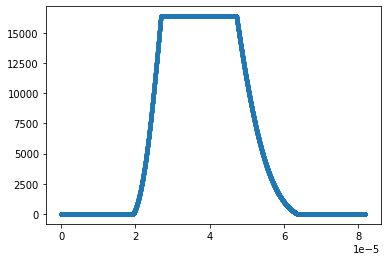

In [ ]:
numb_event=index_saturated[6]
plt.plot(time_axis,list_event[numb_event],ls="",marker=".")

In [ ]:
def gaussian(x, N, mu,sigma):
    return N * np.exp(-0.5*((x-mu)/sigma)**2)

flag=1 #if 0 the saturated events will be overwritten in the same array, otherwise saturated events will be filled 

threshold_value=50 #select a portion of the event that has a signal discarding samples below the threshold level
saturated_events_fitted=[]

for index_event in index_saturated: #cycle on saturated events
    event=list_event[index_event] #select the event 
    sx=[]
    dx=[]
    graph_sx=[]
    graph_dx=[]
    small_points_dx=[]
    small_points_sx=[]
    plateau_points=[]

    plateau_points=[i for i in range(len(event)) if(event[i]==saturation_point)] #range of x_points where the plateau is located

    len_Plateau=len(plateau_points)

    
    #             _________________
    #            /|               |\
    #           / |               | \
    # ---------/---------------------\-------------------
    #_________/   |               |   \______________
    #         |   |    plateau    |   |
    #         |   |               |   |
    # small   |   |___            |   |_     small points
    # points  | graph |           |graph|       dx
    #  sx     |   sx  |           | dx  |
    #
    #

    small_points_sx=[i for i in range(len(event)) if(event[i]<threshold_value and i<plateau_points[0])]
    sx=[i for i in range(plateau_points[0]) if(event[i]>=threshold_value and event[i]<saturation_point)]
    dx=[i for i in range(plateau_points[0],len(event)) if(event[i]>=threshold_value and event[i]<saturation_point)]
    graph_sx=[event[i] for i in range(plateau_points[0]) if(event[i]>=threshold_value and event[i]<saturation_point)]
    graph_dx=[event[i] for i in range(plateau_points[0],len(event)) if(event[i]>=threshold_value and event[i]<saturation_point)]
    small_points_dx=[i for i in range(len(event)) if(event[i]<threshold_value and i>plateau_points[0])]

    #filling the right arrays
    x_graph=np.zeros(len(sx)+len(dx))
    np.concatenate((sx,dx),out=x_graph)
    graph=np.zeros(len(graph_sx)+len(graph_dx))
    np.concatenate((graph_sx,graph_dx),out=graph)

    #fitting
    init_vals = [saturation_point,plateau_points[int(len(plateau_points)/2)] ,len(plateau_points)]  # for [N,mu, wid]
    best_vals, covar = curve_fit(gaussian, x_graph, graph,p0=init_vals) 

    gaussian_event=gaussian(samples_axis,best_vals[0],best_vals[1],best_vals[2])
    
    if(flag==0):
        list_event[index_event]=gaussian_event
    else:
        saturated_events_fitted.append(gaussian_event)

/usr/local/lib/python3.7/dist-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


In [ ]:
non_saturated_events=np.delete(list_event,index_saturated,axis=0)

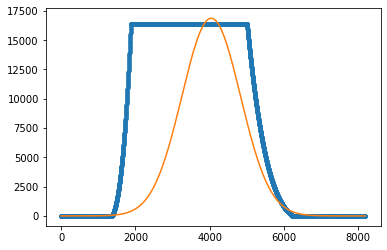

In [ ]:
numb_event=index_saturated[9]
plt.plot(samples_axis,list_event[numb_event],ls="",marker=".")
plt.plot(samples_axis,saturated_events_fitted[numb_event])

In [ ]:
non_sat_values_integrals=[integrate.trapz(event,time_axis) for event in non_saturated_events] #evaluating the spectrum
sat_values_integrals=[integrate.trapz(event,time_axis) for event in saturated_events_fitted]

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3208: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).size
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


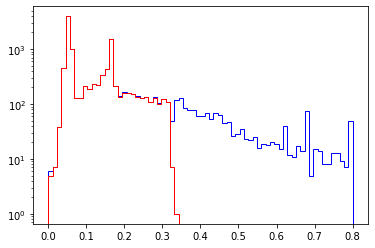

In [ ]:
numb_bins=70
plt.hist((non_sat_values_integrals,sat_values_integrals),bins=numb_bins,histtype="step",color=("red","blue"),range=(0.0,0.8),stacked=True)
#plt.hist(sat_values_integrals,bins=numb_bins,histtype="step",color="blue",range=(0.0,0.8),stacked=True)
plt.yscale("log")
plt.show()

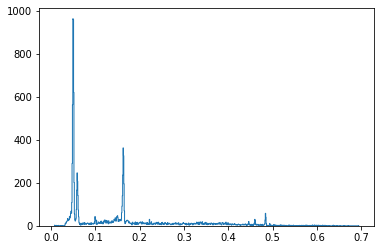

In [ ]:
#histogram of the spectrum
numb_bins=800  #try to change this maybe

plt.hist(values_integrals,bins=numb_bins,histtype="step")
#plt.ylim(0,200)   #to cut the y axis 
#plt.xlim(-0.1,0.1)
plt.show()

In [ ]:
np.savetxt("Ge_Ba133_2000_g100_6_sat.txt",sat_values_integrals)
np.savetxt("Ge_Ba133_2000_g100_6_unsat.txt",non_sat_values_integrals)

In [ ]:
f= open('Ge_Ba133_2000_g100_6_sat.txt', 'r')
f2=open('Ge_Ba133_2000_g100_6_unsat.txt', 'r')
fnuovo=open('Ge_Ba133_2000_g100_6all.txt', 'a')
testo1=f.read()
testo2=f2.read()
fnuovo.write(testo1)
fnuovo.write(testo2)
f.close()
f2.close()
fnuovo.close()

In [ ]:
#Unione file txt a due a due

#unisce i due txt e lo salva in un uno nuovo
#1 e 2 in tot
f= open('Ge_Ba133_2000_g100_1all.txt', 'r')
f2=open('Ge_Ba133_2000_g100_2all.txt', 'r')
fnuovo=open('Ge_Ba133_2000_g100_tot.txt', 'a')
testo1=f.read()
testo2=f2.read()
fnuovo.write(testo1)
fnuovo.write(testo2)
f.close()
f2.close()
fnuovo.close()


#aggiunge il txt a quello che c'è già

#3 in tot
f= open('Ge_Ba133_2000_g100_tot.txt', 'a')
f2=open('Ge_Ba133_2000_g100_3all.txt', 'r')
testo=f2.read()
f.write(testo)
f2.close()
f.close()

#4 in tot
f= open('Ge_Ba133_2000_g100_tot.txt', 'a')
f2=open('Ge_Ba133_2000_g100_4all.txt', 'r')
testo=f2.read()
f.write(testo)
f2.close()
f.close()

#5 in tot
f= open('Ge_Ba133_2000_g100_tot.txt', 'a')
f2=open('Ge_Ba133_2000_g100_5all.txt', 'r')
testo=f2.read()
f.write(testo)
f2.close()
f.close()

#6 in tot
f= open('Ge_Ba133_2000_g100_tot.txt', 'a')
f2=open('Ge_Ba133_2000_g100_6all.txt', 'r')
testo=f2.read()
f.write(testo)
f2.close()
f.close()

In [ ]:
nomefile="Ge_Ba133_2000_g100_tot (3).txt" 
f=open(nomefile,"r")
lines=f.readlines() #leggo linee del file
colonna1=[]
for riga in lines:
    colonna1.append(riga.split()[0])
f.close()

all_integrals_values = np.asarray(colonna1, dtype=np.float64)


In [ ]:
len(all_integrals_values)

63540

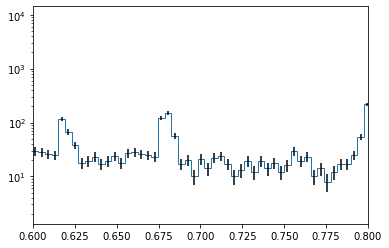

In [ ]:
#histogram of the spectrum for all data of Barium

numb_bins=252  #try to change this maybe

histogram=plt.hist(all_integrals_values,bins=numb_bins,histtype="step",range=(0,1))

#grandezze legate ai bin
value=histogram[0]  
sigma_value=np.sqrt(value)
center_bins=[0.5*(histogram[1][i]+histogram[1][i+1]) for i in range(len(histogram[1])-1)]
center_bins=np.array(center_bins)

plt.bar(center_bins,value,yerr=sigma_value,alpha=0)
#plt.ylim(0,200)   #to cut the y axis 
#plt.xlim(0.1,0.2) #primi picchi
plt.xlim(0.6,0.8) #ultimi picchi
plt.yscale("log")
plt.show()


In [ ]:
#spostamento file in drive
!mv /content/Ge_Ba133_2000_g100_tot.txt /content/drive/MyDrive/Lab\ HPGE

Calibrazione dello spettro

In [ ]:
#TABELLE Ba133

In [ ]:
#Gammas from 133Ba (10.51 y 5)

# Eg (keV)    Ig (%)    Decay mode

# 53.161 1 	  2.199 22 	    e ###
# 79.6139 26 	2.62 6 	      e 
# 80.9971 14 	34.06 27 	    e ###
# 160.613 8 	0.645 8 	    e 
# 223.234 12 	0.450 4 	    e 
# 276.398 2 	7.164 22 	    e ###
# 302.853 1 	18.33 6 	    e #
# 356.017 2 	62.05 19 	    e ###
# 383.851 3 	8.94 3 	      e #

In [ ]:
# X-rays from 133Ba (10.51 y 5)
# E (keV)   	I (%)    	Assignment
# 3,795  	0.24 3  	Cs Ll
# 4,142  	0.110 11  	Cs Lh
# 4,272  	0.66 8  	Cs La2
# 4,286  	6.0 7  	Cs La1
# 4,620  	3.8 4  	Cs Lb1
# 4,649  	0.56 11  	Cs Lb4
# 4,717  	0.93 19  	Cs Lb3
# 4,781  	0.048 6  	Cs Lb6
# 4,934  	1.19 14  	Cs Lb2
# 5,281  	0.54 6  	Cs Lg1
# 5,542  	0.15 3  	Cs Lg2
# 5,553  	0.22 5  	Cs Lg3
# 30,270  0.00401 14  Cs Ka3
# 30,625  	34.9 9  	Cs Ka2
# 30,973  	64.5 17  	Cs Ka1 ###
# 34,920  	5.99 16  	Cs Kb3
# 34,987  	11.6 3  	Cs Kb1
# 35,252  	0.123 5  	Cs Kb5
# 35,818  	3.58 9  	Cs Kb2
# 35,907  	0.74 3  	Cs Kb4

In [ ]:
#picchi più alti per Ba133 estrapolati dalle tabelle

E_real_peaks=[30.973,53.161,80.9971,276.398,302.853,356.017,383.851] #keV
E_real_peaks=np.array(E_real_peaks)

#stima spacca e pesa dal grafico -->incertezza notevole

x_uncalibrated_peaks=[0.06,0.1,0.16,0.62,0.68,0.8,0.87] #scala non calibrata
x_uncalibrated_peaks=np.array(x_uncalibrated_peaks)

In [ ]:
def gaussianh(x, N, mu,sigma,h):
    return N * np.exp(-0.5*((x-mu)/sigma)**2)+h

In [ ]:
len(center_bins)

252

In [ ]:
all_mu=[]
all_sigma=[]

for Xpeak in x_uncalibrated_peaks:
  XforFit=[]
  YforFit=[] 
  for i in range(len(center_bins)):
    if(center_bins[i] > Xpeak):
      for j in range(i-5,i+5):
        XforFit.append(center_bins[j])
        YforFit.append(value[j])

      init_vals = [140,Xpeak ,(center_bins[i+5]-center_bins[i])/2,60]
      best_vals_gauss, covar_gauss = curve_fit(gaussianh,XforFit,YforFit,sigma=np.sqrt(YforFit),p0=init_vals) 
      print(best_vals_gauss[1])
      all_mu.append(best_vals_gauss[1])
      all_sigma.append(covar_gauss[1][1])    

      break

all_mu=np.array(all_mu)
all_sigma=np.array(all_sigma)

0.048096688747417536
0.11068376543125538
0.16022853705245568
0.6184260860897823
0.6794351605720993
0.802808406321564
0.8669252632348854


In [ ]:
print(all_sigma)

[2.28945143e-07 4.70854836e-04 1.24972339e-06 3.11984811e-07
 1.42804730e-07 8.24261642e-08 3.22473388e-07]


0.002323068955172001 -0.02424863053703797
[[ 6.80964510e-12 -1.93903230e-09]
 [-1.93903230e-09  6.43170894e-07]]
13.933485934388129


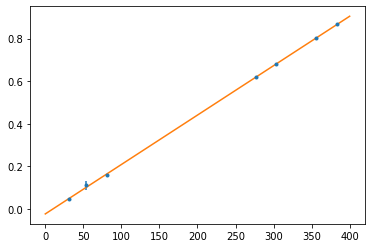

In [ ]:
def linear(x, m, q):
  return m*x+q

def Chi2(oss,real,sigma2):
  chi=0
  for i in range(len(oss)):
    chi+=(oss[i]-real[i])**2/sigma2[i]
  return chi

#fitting 
init_vals = [1000,20]  # for [N,mu, wid]
best_vals, covar = curve_fit(linear, E_real_peaks, all_mu,p0=init_vals, sigma=np.sqrt(all_sigma)) 

x=np.linspace(0,400,1000)

plt.errorbar(E_real_peaks,all_mu,yerr=np.sqrt(all_sigma),fmt=".")
plt.plot(x,linear(x,best_vals[0],best_vals[1]))
print(best_vals[0],best_vals[1])
print(covar)
print(Chi2(all_mu,linear(E_real_peaks,best_vals[0],best_vals[1]),all_sigma))

Residui

In [ ]:
residuals=(all_mu-linear(E_real_peaks,best_vals[0],best_vals[1]))/np.sqrt(all_sigma)
print(residuals)

[ 0.82114778  0.52701172 -3.29604348  1.04394823  0.3582709   0.01740388
 -0.94819272]


Spettro calibrato

In [ ]:
calibrated_integral_values=(all_integrals_values-best_vals[1])/best_vals[0]

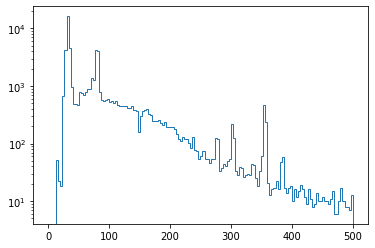

In [ ]:
numb_bins=150  #try to change this maybe

plt.hist(calibrated_integral_values,bins=numb_bins,histtype="step",range=(0,500))
#plt.ylim(0,200)   #to cut the y axis 
#plt.xlim(120,180) #primi picchi
#plt.xlim(0.8,0.9) #ultimi picchi
plt.yscale("log")
plt.show()